In [50]:
import pickle

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# 1. EDA


In [51]:
raw_data = pd.read_csv("data/bank+marketing/bank/bank-full.csv", sep=";")

In [52]:
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [53]:
raw_data.shape

(45211, 17)

In [54]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Verteilung der Zielvariable

Die Zielvariable im Datensatz ist nicht gleichmäßig verteilt.


In [55]:
(raw_data["y"].value_counts() / raw_data["y"].shape).round(2)

y
no    0
yes   0
Name: count, dtype: float64

<Axes: xlabel='y'>

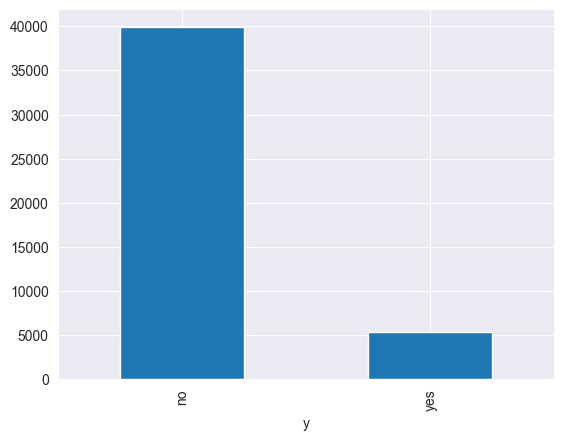

In [56]:
raw_data["y"].value_counts().plot(kind="bar")

## Analyse der numerischen Features

In [57]:
raw_data["y_encoded"] = raw_data["y"].map({"yes": 1, "no": 0})

Zur Entscheidung, welche der rein technisch numerischen Features auch inhaltlich numerische Features sind, wurde die Beschreibung des Datensatzen dazugezogen.
D. h. das Feature "days" wurde hier ausgeschlossen, da es sich um eine Art Datumswert handelt.

In [58]:
numerical_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
numerical_features = raw_data[numerical_cols + ["y_encoded"]]

In der Datensatzbeschreibung wurde geschildert, dass das Feature "pdays" (number of days that passed by after the client was last contacted from a previous campaign) mit einem Wert von -1 codiert ist, sollte noch kein Kontakt zum Kunden hergestellt worden sein.

**36954** mal, also mit signifikanter Anzahl, tritt dieser Verhalten tatsächlich auf.

Ich habe mich im Folgenden dennoch dazu entschieden, dieses Feature nicht anderweitig zu codieren.

In [59]:
numerical_features.loc[numerical_features["pdays"] == -1, "pdays"].count()

np.int64(36954)

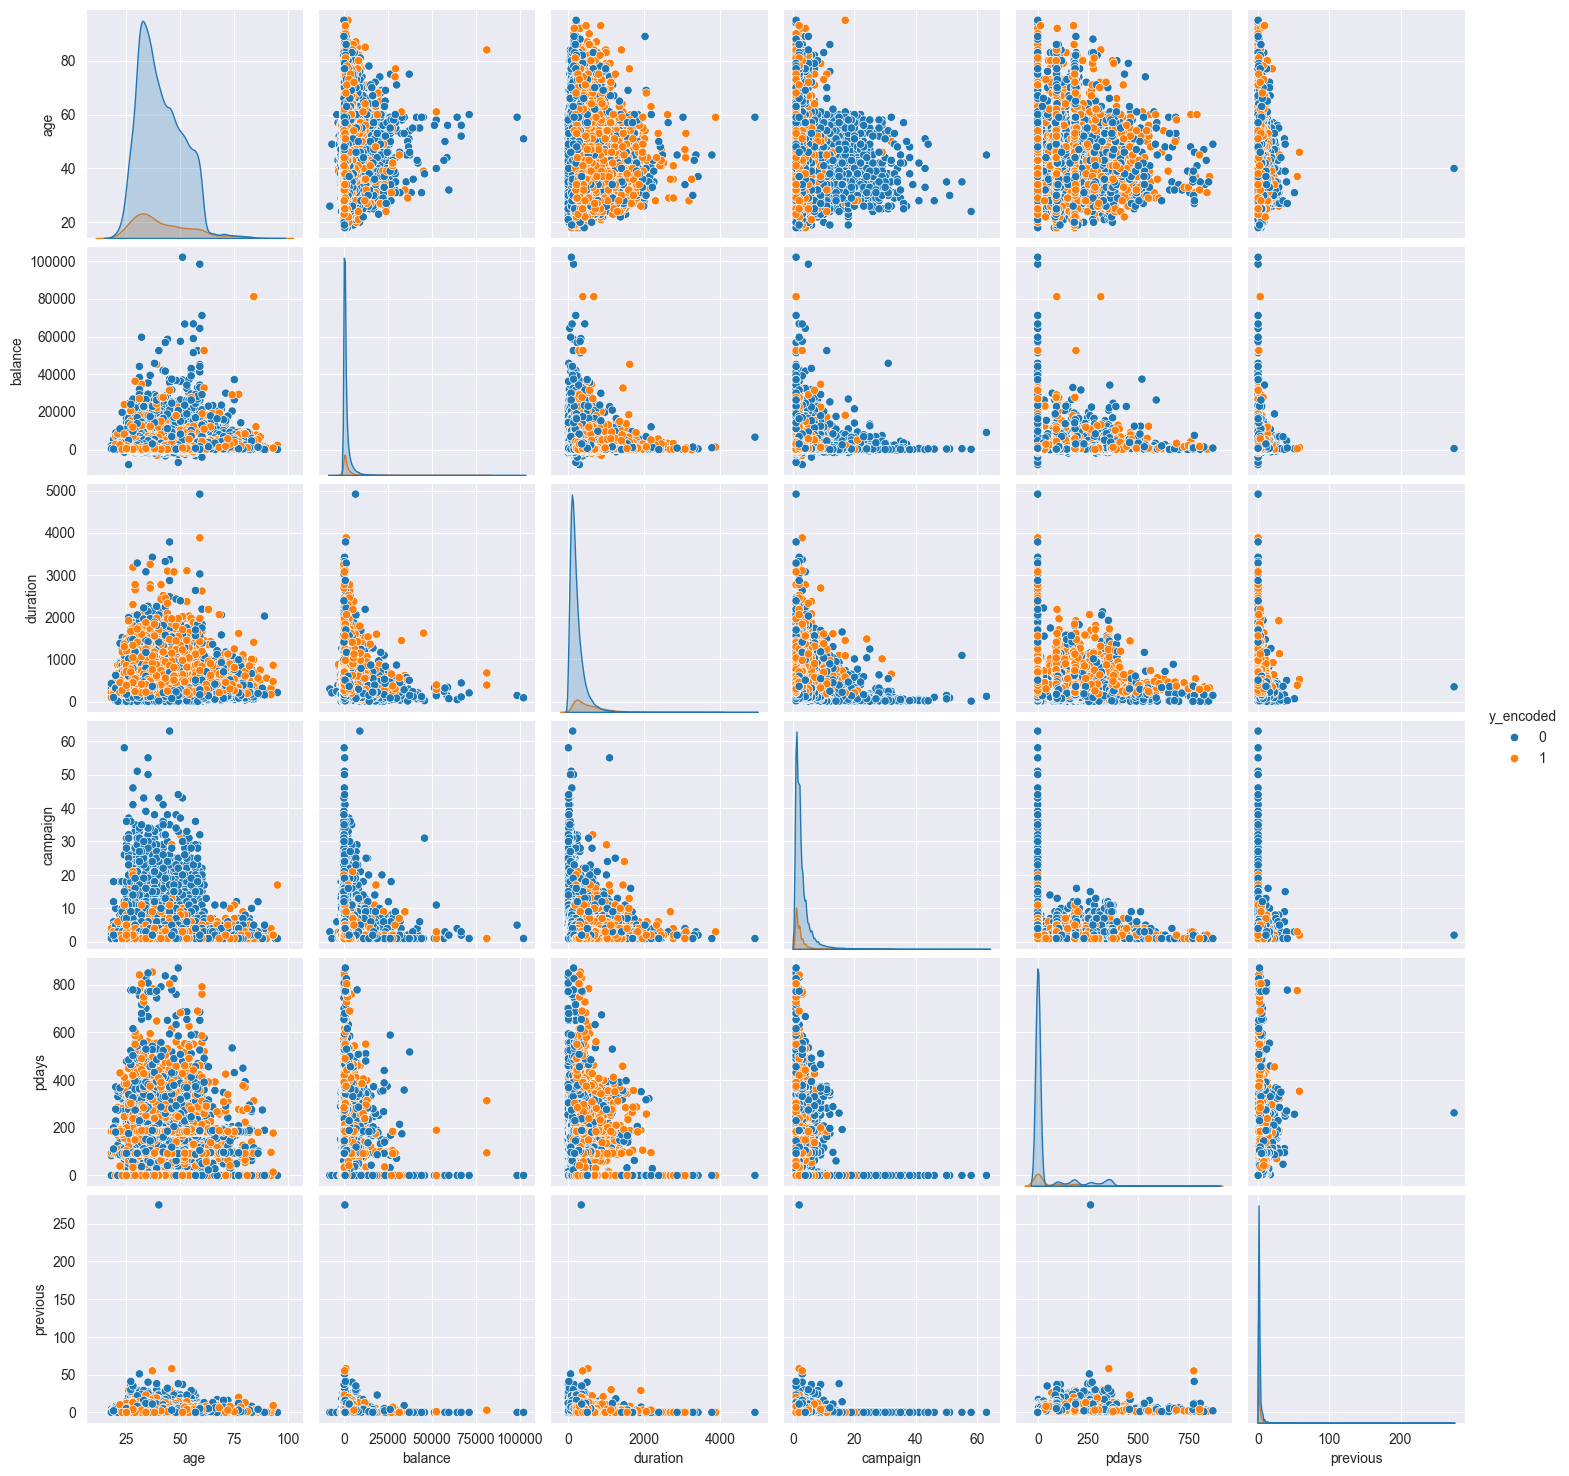

In [60]:
sns.pairplot(numerical_features, diag_kind="kde", hue="y_encoded")

### Untersuchung: Korrelationsstrukturen der Features

Es sind keinerlei signifikante Korrelationsstrukturen in den Features erkennbar, was darauf hindeutet, dass **keine Kollinearität** vorhanden ist.

### Verwendung numerischer Features

Alle numerischen Features **außer dem Feature "day"** werden in der nachfolgenden Modellanpassung verwendet, da Kollinearität keinen Störfaktor darstellt.


In [12]:
correlation_matrix = numerical_features.drop(columns="y_encoded").corr()

<Axes: >

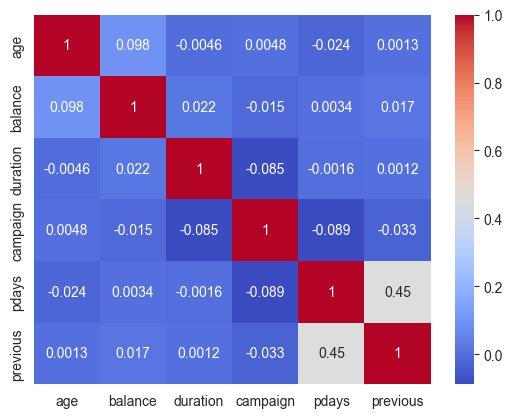

In [13]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

## Analyse der kategorischen Features

In [14]:
categorical_features = raw_data.select_dtypes(include="object")

### Kategorie "unknown"

Die Kategorie "unknown" fällt auf, da sie, wie in der Beschreibung des Datensatzes geschrieben, in fast allen kategorischen Features enthalten ist. \
Aus diesem Grund wird die Ausprägung nicht fallen gelassen oder imputiert, sondern unverändert in der nachfolgenden Modellanpassung verwendet.


### Zusätzliche Erkenntnis: Kredit-Ausfälle

Außerdem ist ersichtlich, dass Personen mit einem aktuellen Kreditausfall keinen weiteren Kredit abschließen.

### Verwendung kategorischer Features

Alle kategorischen Features, **inklusive des Features "month"**, werden nach einem entsprechenden Encoding in der nachfolgenden Modellanpassung verwendet.


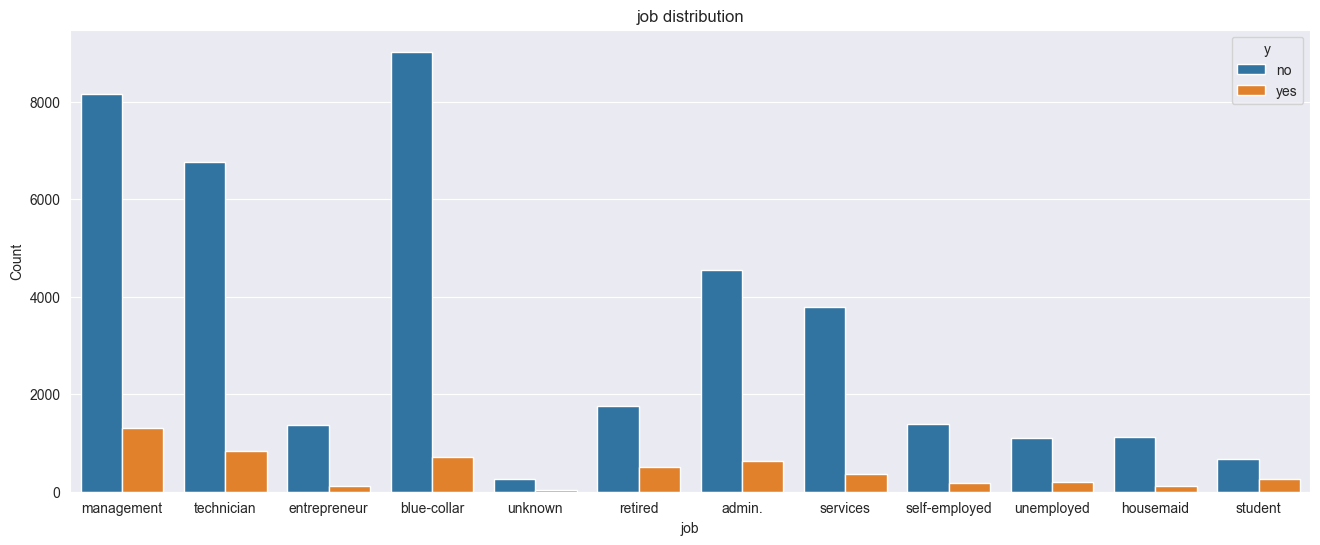

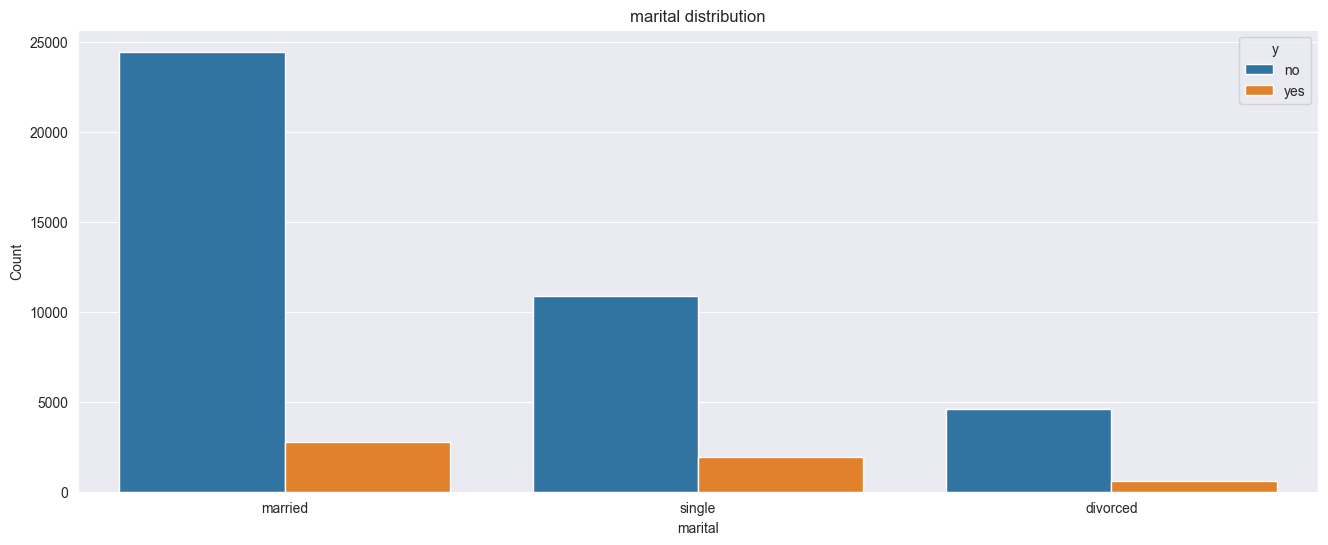

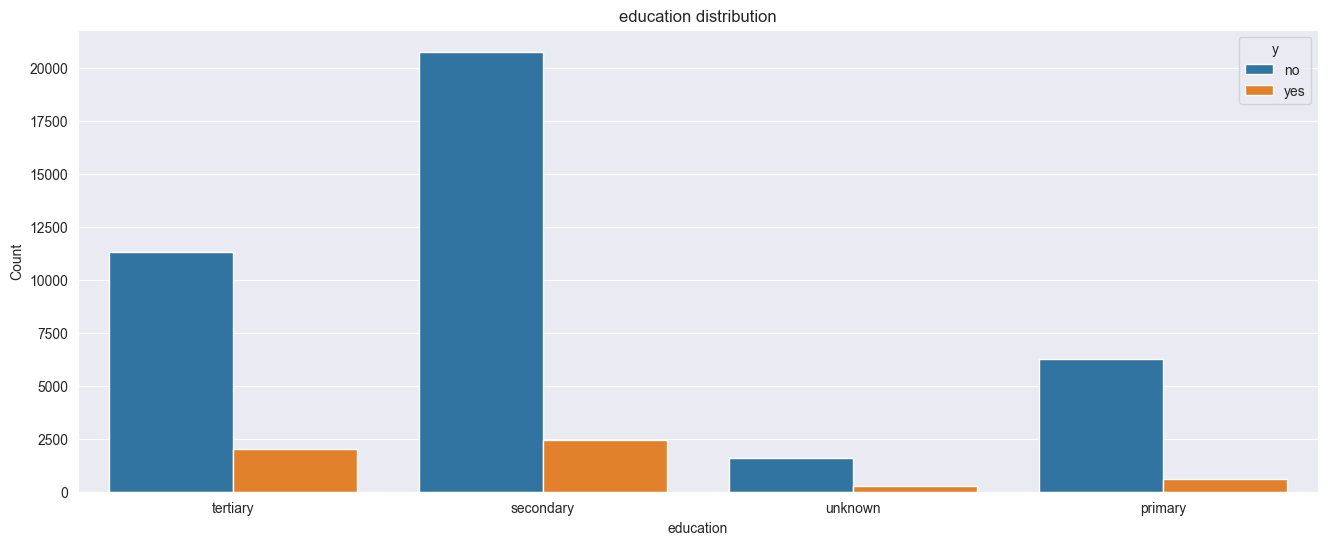

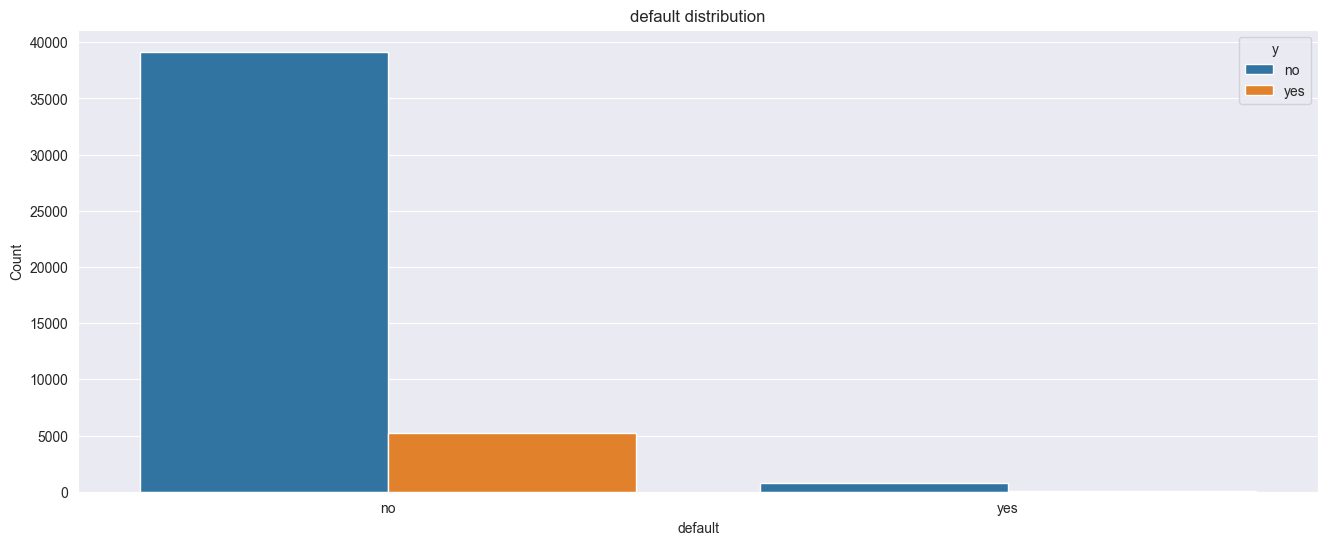

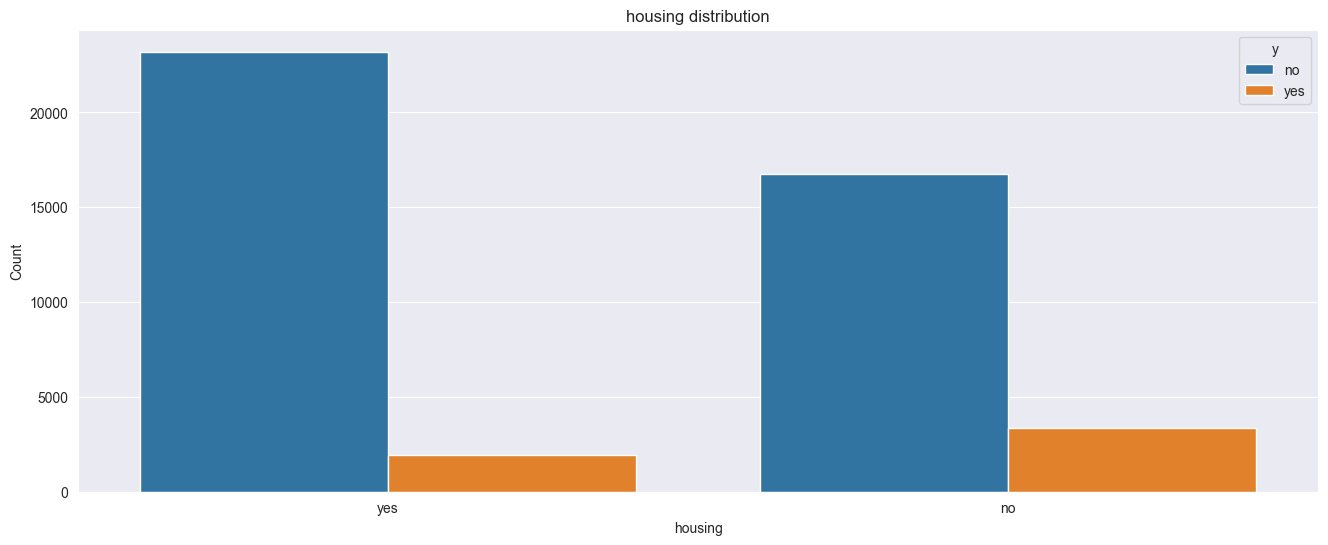

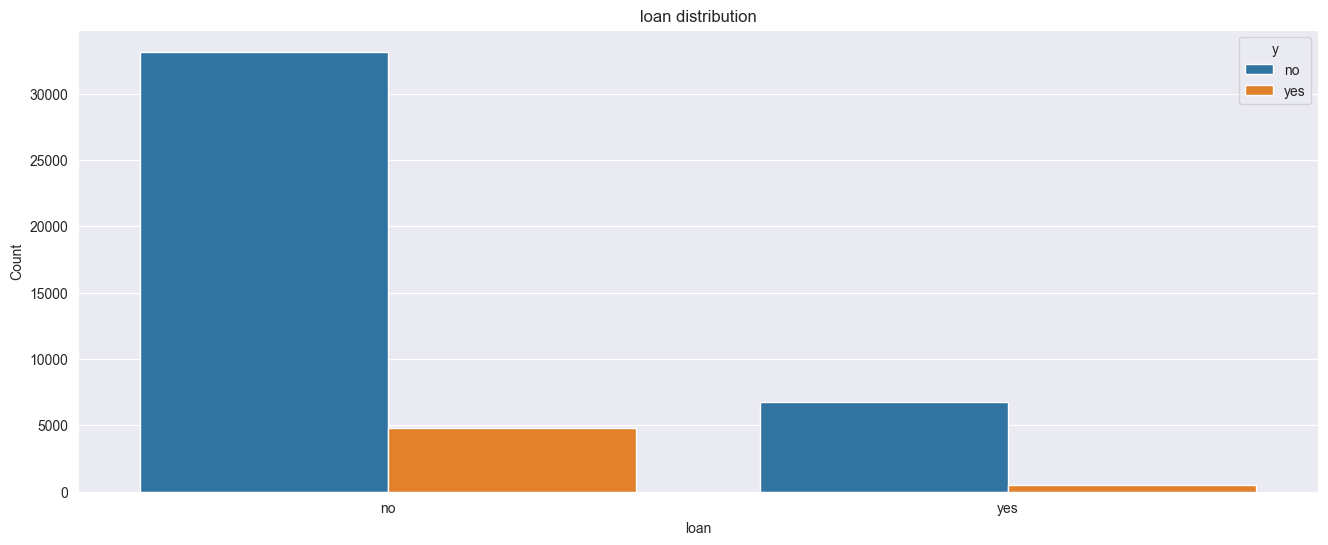

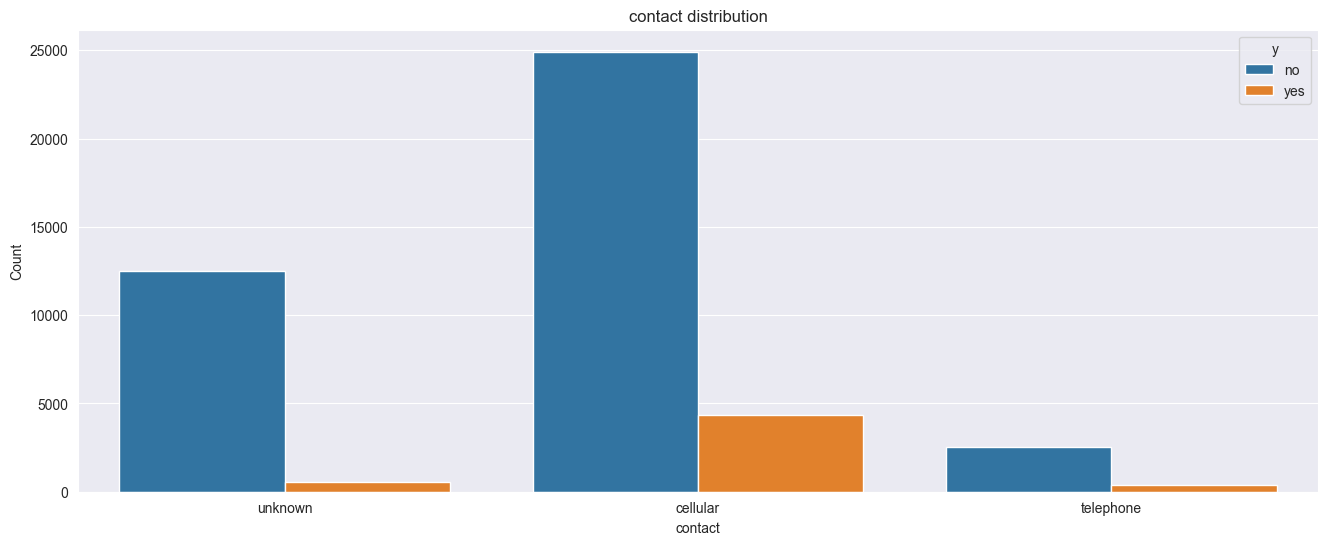

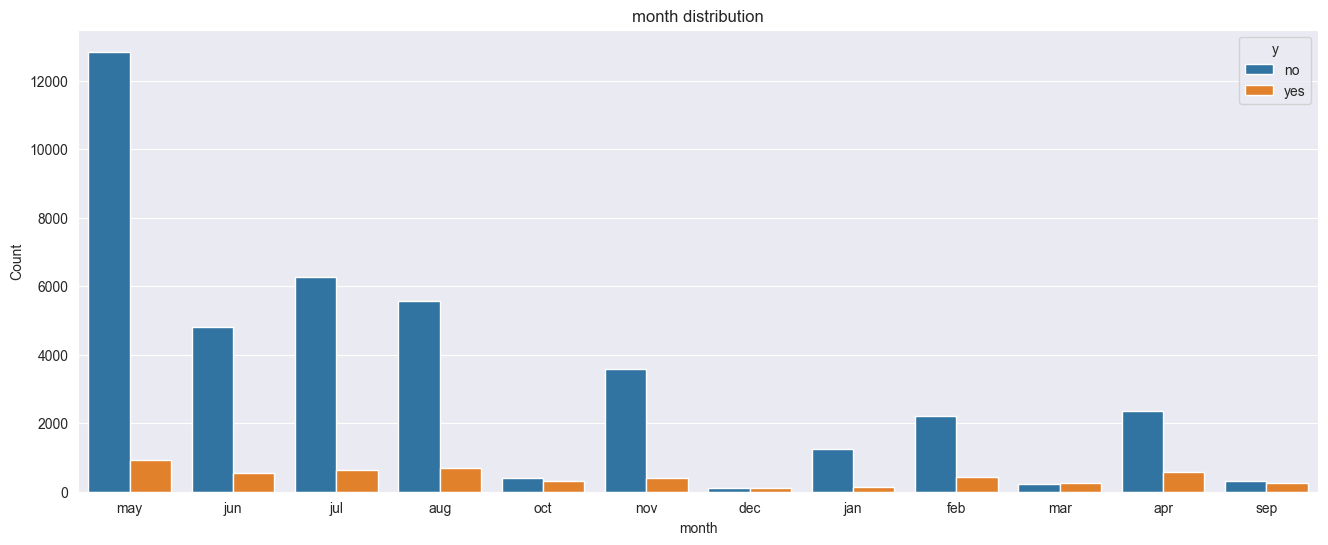

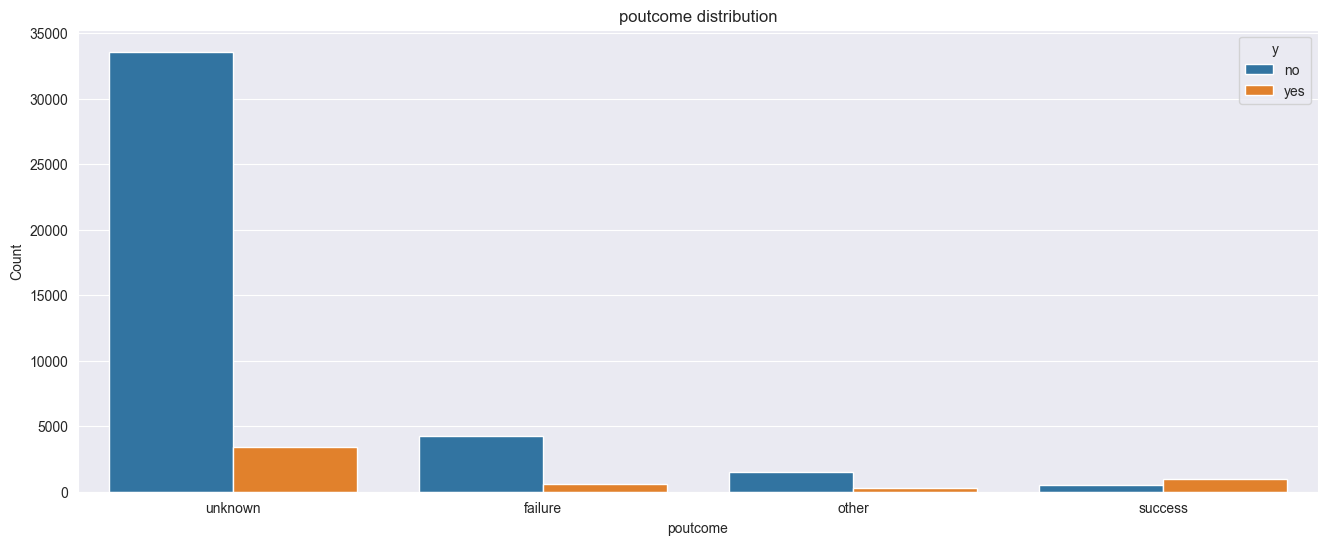

In [15]:
for feature in categorical_features.drop(columns="y").columns:
    plt.figure(figsize=(16, 6))
    sns.countplot(data=categorical_features, x=feature, hue="y")
    plt.title(f"{feature} distribution")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="y")
    plt.show()

# 2. Data preprocessing

Die Vorverarbeitung der Features teilt sich in zwei Schritte:

1. **Standardisierung numerischer Merkmale**:
   Alle numerischen Merkmale werden so transformiert, dass sie einen Mittelwert von 0 und eine Standardabweichung von 1 haben, um für die Modellierung geeignet zu sein.

2. **One-Hot-Encoding kategorischer Merkmale**:
   Alle kategorischen Merkmale werden in binäre Indikatoren umgewandelt, um ihre unterschiedlichen Kategorien zu repräsentieren.



In [16]:
y = raw_data["y_encoded"]
features = raw_data.drop(columns=["y", "y_encoded", "day"])

In [17]:
numerical_features = numerical_features.drop(columns="y_encoded")

scaler = StandardScaler()
standardized_numerical_features = scaler.fit_transform(numerical_features)

features[numerical_features.columns] = standardized_numerical_features

In [18]:
features[numerical_features.columns].describe()

,age,balance,duration,campaign,pdays,previous
count,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04
mean,2.112250e-16,1.760208e-17,6.035001e-17,3.017500e-17,2.011667e-17,4.023334e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-2.159994e+00,-3.081149e+00,-1.002478e+00,-5.693506e-01,-4.114531e-01,-2.519404e-01
25%,-7.473845e-01,-4.237719e-01,-6.025167e-01,-5.693506e-01,-4.114531e-01,-2.519404e-01
50%,-1.823406e-01,-3.002800e-01,-3.035165e-01,-2.465603e-01,-4.114531e-01,-2.519404e-01
75%,6.652252e-01,2.158743e-02,2.362370e-01,7.622994e-02,-4.114531e-01,-2.519404e-01
max,5.091402e+00,3.309478e+01,1.809470e+01,1.944365e+01,8.297431e+00,1.191360e+02


In [19]:
features = pd.get_dummies(features, columns=categorical_features.drop(columns="y").columns)

### Data Leakage

Das Feature "duration" wird nach genauerer Abwägung aus dem erklärenden Datensatz ausgeschlossen, da die Gesprächsdauer erst bekannt ist, nachdem ein Gespräch beendet ist, wobei dann auch die Variable "y" bekannt wäre.
In einem produktiv genutzten Algorithmus wäre dieses Feature also nicht zu verwenden.

In [20]:
features = features.drop(columns="duration")

# 3. Modelltraining

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.333, random_state=42)

### Art der Cross-Validierung
Es wird eine 10-Fold StratifiedKFold - CV genutzt, um die besten Hyperparameter der Modelle zu finden. \
Diese Art der CV wurde gewählt, um die Verteilung der Features sowie vor allem von y aus dem Gesamtdatensatz in den einzelnen Folds zu erhalten.

### Art des Performancemaßes
Die Güte / Performance einer jeden Kombination aus Modell und Hyperparameterset wurde anhand der **"Area under the ROC (receiver-operating-curve)" ROC-AUC** bestimmt.

Dieses Gütemaß wurde gewählt, weil es unabhängig von ggf. zu bestimmenden Threshold-Werten ist (ab welcher vorhergesagten Wahrscheinlichkeit für ein Ereignis wird eine Klasse vergeben).

Des Weiteren ist das Maß gut interpretierbar. Eine ROC-AUC von 0,5 deutet auf ein Modell hin, welches keinerlei diskriminierende Kraft hat ("coint-flip"), wohingegen eine ROC-AUC von 1 auf eine perfekt diskriminierendes Modell hindeutet.

Es berücksichtigt dabei, da es sich auf die ROC bezieht, sowohl die _Sensitivität_ (wie viele positive Werte wurden korrekt klassifiziert) als auch die _Spezifität_ (wie viele negative Werte wurden korrekt klassifiziert), wobei bei einer Klassifikation immer beide Seiten gleichermaßen berücksichtigt werden sollten.

In [22]:
# Stratified 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a scorer using ROC-AUC
roc_auc_scorer = make_scorer(roc_auc_score)

In [23]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

# Classifiers
rf = RandomForestClassifier()
mlp = MLPClassifier(max_iter=500)
xgb = XGBClassifier(use_label_encoder=False, use_eval_metric='logloss')

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    scoring=roc_auc_scorer,
    cv=cv,
    random_state=42,
    verbose=3
)
random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_grid_mlp,
    scoring=roc_auc_scorer,
    cv=cv,
    random_state=42,
    verbose=3
)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    scoring=roc_auc_scorer,
    cv=cv,
    random_state=42,
    verbose=3
)

Achtung: Das Fitting muss nicht nochmal ausgeführt werden. Es würde reichen, die abgelegten .pkl - Dateien zu laden

In [ ]:
# Fit the models
random_search_rf.fit(X_train, y_train)
random_search_mlp.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)

In [27]:
with open("rf_model.pkl", "wb") as file:
    pickle.dump(random_search_rf, file)

In [30]:
with open("mlp_model.pkl", "wb") as file:
    pickle.dump(random_search_mlp, file)

In [32]:
with open("xg_model.pkl", "wb") as file:
    pickle.dump(random_search_xgb, file)

Zu Benchmarkzwecken wird auch eine klassische logistische Regression an die Daten angepasst.

In [36]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

# 4. Modellevaluation

Ergebnis der Evaluation ist, dass alle Modelle mit den vorhandenen Informationen ähnlich gut ungesehene Beobachtungen klassifizieren können. Alle betrachteten Modelle sind dabei weit entfernt von einem rein zufällig klassifizierenden Algorithmus (siehe gestrichelte Linie).

Zusätzlich ist in dem ROC-Plot zu erkennen, dass sich die Klassifikationsergebnisse i. S. d. True Postitve - bzw. False Postive - Werte aller Algorithmen bei einer Veränderung der Klassifikationsthresholds ähnlich verhalten.

Mit minimalem Abstand schafft es allerdings der XGBoost den besten ROC-AUC-Score auf dem Testdatensatz zu erzielen. Somit würde ich dieser Algorithmus in Produktion verwenden.



In [43]:
# Predict probabilities on the test set
rf_probs = random_search_rf.predict_proba(X_test)[:, 1]
mlp_probs = random_search_mlp.predict_proba(X_test)[:, 1]
xgb_probs = random_search_xgb.predict_proba(X_test)[:, 1]
lr_probs = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC-AUC scores
roc_auc_rf = roc_auc_score(y_test, rf_probs)
roc_auc_mlp = roc_auc_score(y_test, mlp_probs)
roc_auc_xgb = roc_auc_score(y_test, xgb_probs)
roc_auc_lr = roc_auc_score(y_test, lr_probs)

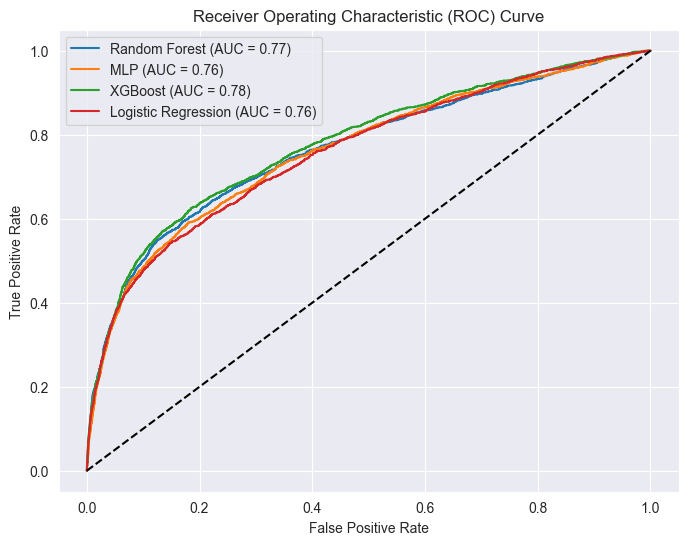

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

for model_probs, label in zip(
    [rf_probs, mlp_probs, xgb_probs, lr_probs],
    [ "Random Forest", "MLP", "XGBoost", "Logistic Regression"]
):
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_test, model_probs):.2f})")

ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic (ROC) Curve")
ax.legend(loc="best")
plt.show()

# 5. Weiterführende Fragen

•  **Würden Sie für die Voraussage noch weitere Datenpunkte in Erwägung ziehen?** \
   Ja, beispielweise könnten makroökonomische Indikatoren wie die Arbeitslosenquote, die Inflationsrate bzw. einen Verbraucherpreisindex, den Leitzins wie auch Häuserpreisindizes genutzt werden, da diese rein ökonomisch mit dem Willen, einen Loan abzuschließen, in Verbindung stehen. Dementsprechend würde ich davon ausgehen, dass diese eine starke erklärende Kraft haben und somit die Algorithmik verbessern.

• **Können die Erkenntnisse Ihrer Analyse auch für andere Bereiche der Bank verwendet werden?** \
Grundsätzlich konnte mit der Studie gezeigt werden, dass es im Kontext des Geschäftes von Banken möglich ist, mit Methoden des maschinellen Lernens präzise Vorhersagen zu treffen.

Anwendung finden könnten solche Methoden bspw. auch beim automatischen Auffinden von Betrugsfällen, bei der Bewertung der Kreditwürdigkeit von möglichen Kunden und bei der Kundensegmentierung. In letzterem Fall könnten anschließend Produkte, welche besser an die Segmente angepasst sind, entwickelt und vertrieben werden.